In [28]:
import pandas as pd
import numpy as np
from numpy.random import normal, seed

from scipy import stats
from scipy.stats import norm

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima_process import ArmaProcess, arma_generate_sample
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.stats.stats import pearsonr, spearmanr, kendalltau 

from pylab import rcParams

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [3]:
google = pd.read_csv("google.csv", parse_dates = ["Date"], index_col = "Date").drop("Volume", axis = 1)
google.index = pd.date_range("2017-01-01", periods = 20, freq = "D")
google.head()

,Open,High,Low,Close
2017-01-01,778.81,789.63,775.80,786.14
2017-01-02,788.36,791.34,783.16,786.90
2017-01-03,786.08,794.48,785.02,794.02
2017-01-04,795.26,807.90,792.20,806.15
2017-01-05,806.40,809.97,802.83,806.65


# Train & Test based on Date:

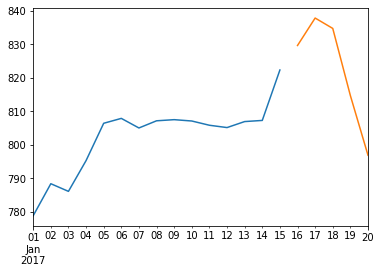

In [8]:
train = google.loc[:"2017-01-15", "Open"]
test = google.loc["2017-01-16":, "Open"]

fig, ax = plt.subplots()

train.plot(ax = ax)
test.plot(ax = ax)
plt.show()

# Stationarity: A Time series should be before modelling...

- Trend stationary: Trend is zero
- Variance is Constant.
- Autocorrelation is constant.

## Augmented Dickey-Fuller Test: - Trend Stationary Test:

- Null Hypothesis: The series is non-stationary due to trend...

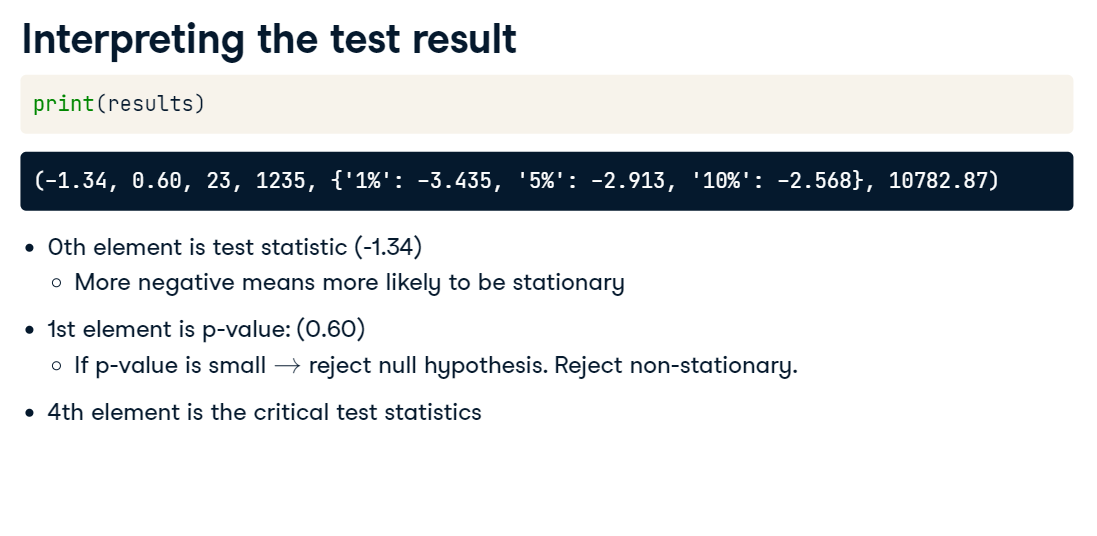

In [9]:
display(Image("./Image/adfuller.png"))

In [10]:
adfuller(google["Open"])

(-5.897877163341966,
 2.823197364894063e-07,
 8,
 11,
 {'1%': -4.223238279489106,
  '5%': -3.189368925619835,
  '10%': -2.729839421487603},
 32.07806364852147)

## Convert a Time-Series into Stationary Before Modelling !!!

# Differencing: To make a series stationary (1,2... levels in line with requirements):

In [11]:
# Example data nonsense but...

diff = google.Open.diff().dropna()

adfuller(diff)

(-1.598565804396566,
 0.4843138794399214,
 5,
 13,
 {'1%': -4.068853732362312,
  '5%': -3.1271488757396453,
  '10%': -2.7017297633136095},
 68.79944940470705)

## Other transformations: (log, sqrt, proportional change...)

In [17]:
log = np.log(google.Open)
sqrt = np.sqrt(google.Open)
prop = (google.Open.shift(1)/google.Open).dropna()

In [13]:
adfuller(log)

(-5.587115615044377,
 1.3550440886138973e-06,
 8,
 11,
 {'1%': -4.223238279489106,
  '5%': -3.189368925619835,
  '10%': -2.729839421487603},
 -113.56404583078296)

In [14]:
adfuller(sqrt)

(-5.739905281070634,
 6.310800251790389e-07,
 8,
 11,
 {'1%': -4.223238279489106,
  '5%': -3.189368925619835,
  '10%': -2.729839421487603},
 -55.98379492895775)

In [18]:
adfuller(prop)

(-1.5535149999360327,
 0.5068919395633572,
 5,
 13,
 {'1%': -4.068853732362312,
  '5%': -3.1271488757396453,
  '10%': -2.7017297633136095},
 -78.97407365209158)

# Modelling:

- AR: Regress on previous values
- MA: Regress on previous errors

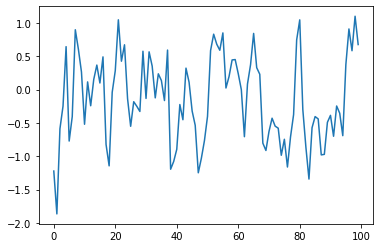

In [23]:
ar_coeffs = [1, -0.5] # Negative of intended
ma_coeffs = [1, 0.2] 

y = arma_generate_sample(ar_coeffs, ma_coeffs, nsample = 100, scale = 0.5)

pd.Series(y).plot(); plt.show()

In [24]:
model = ARMA(y, order = (1,1))
results = model.fit()

print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(1, 1)   Log Likelihood                 -78.272
Method:                       css-mle   S.D. of innovations              0.528
Date:                Sun, 19 Dec 2021   AIC                            164.544
Time:                        23:03:53   BIC                            174.965
Sample:                             0   HQIC                           168.762
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1423      0.117     -1.215      0.225      -0.372       0.087
ar.L1.y        0.5035      0.137      3.676      0.000       0.235       0.772
ma.L1.y        0.1137      0.144      0.792      0.4

C:\Users\okana\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


## ARMAX: ARMA + Linear Regression 

- ARMA Models with using exogenous (other) variables

In [26]:
model = ARMA(google["High"], order = (1, 2), exog = google["Open"])
results = model.fit()

print(results.summary())

C:\Users\okana\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:                   High   No. Observations:                   20
Model:                     ARMA(1, 2)   Log Likelihood                 -55.004
Method:                       css-mle   S.D. of innovations              3.776
Date:                Sun, 19 Dec 2021   AIC                            122.008
Time:                        23:09:40   BIC                            127.982
Sample:                    01-01-2017   HQIC                           123.174
                         - 01-20-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.4852     48.436      1.414      0.157     -26.448     163.418
Open           0.9206      0.060     15.347      0.000       0.803       1.038
ar.L1.High    -0.0140      1.532     -0.009      0.9

## SARIMAX: Can do everything & more that ARMA does...

In [29]:
model = SARIMAX(google["High"], order = (1, 0, 2), exog = google["Open"])
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                   20
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 -55.978
Date:                Sun, 19 Dec 2021   AIC                            121.956
Time:                        23:19:40   BIC                            126.934
Sample:                    01-01-2017   HQIC                           122.928
                         - 01-20-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open           1.0053      0.002    465.029      0.000       1.001       1.010
ar.L1         -0.1634      0.878     -0.186      0.852      -1.884       1.558
ma.L1          0.0723      1.187      0.061      0.9

C:\Users\okana\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


### If trend is not zero, a must is:

In [38]:
model = SARIMAX(google["High"], order = (1, 0, 2), trend = "c")
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                   20
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 -69.034
Date:                Sun, 19 Dec 2021   AIC                            148.067
Time:                        23:26:52   BIC                            153.046
Sample:                    01-01-2017   HQIC                           149.039
                         - 01-20-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    336.7960    268.873      1.253      0.210    -190.185     863.777
ar.L1          0.5832      0.332      1.759      0.079      -0.067       1.233
ma.L1          0.5480      0.471      1.163      0.2

## PREDICTIONS: .get_prediction()

In [ ]:
forecast = results.get_prediction(start = -15)

mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

lower_vals = confidence_intervals["lower High"]
upper_vals = confidence_intervals["upper High"]

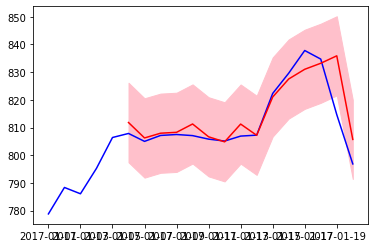

In [47]:
plt.figure()

plt.plot(google.index, google.Open.values, color = "blue", label = "observed")


plt.plot(mean_forecast.index, mean_forecast.values, color = "red", label = "forecast")
plt.fill_between(confidence_intervals.index, lower_vals.values, upper_vals.values, color = "pink")

plt.show()

## Dynamic Predictions:

In [48]:
forecast = results.get_prediction(start = -15, dynamic = True)

mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

lower_vals = confidence_intervals["lower High"]
upper_vals = confidence_intervals["upper High"]

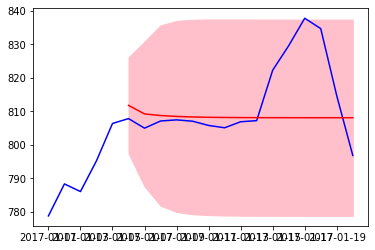

In [49]:
plt.figure()

plt.plot(google.index, google.Open.values, color = "blue", label = "observed")


plt.plot(mean_forecast.index, mean_forecast.values, color = "red", label = "forecast")
plt.fill_between(confidence_intervals.index, lower_vals.values, upper_vals.values, color = "pink")

plt.show()

## Forecast: .get_forecast()

In [50]:
forecast = results.get_forecast(steps = 20)

mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

lower_vals = confidence_intervals["lower High"]
upper_vals = confidence_intervals["upper High"]

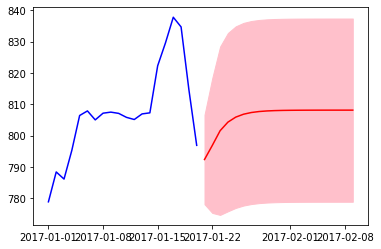

In [51]:
plt.figure()

plt.plot(google.index, google.Open.values, color = "blue", label = "observed")


plt.plot(mean_forecast.index, mean_forecast.values, color = "red", label = "forecast")
plt.fill_between(confidence_intervals.index, lower_vals.values, upper_vals.values, color = "pink")

plt.show()

## ARIMA (Models with Differencing):

- SARIMAX AUTOMATICALLY DOES !!!
- OTHERWISE, DIFFERENCE BACK THE RESULTS !!!

In [53]:
model = SARIMAX(google["High"], order = (1, 1, 2), trend = "c")
results = model.fit()

In [54]:
forecast = results.get_forecast(steps = 20)

mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

lower_vals = confidence_intervals["lower High"]
upper_vals = confidence_intervals["upper High"]

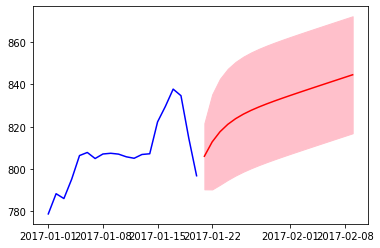

In [55]:
plt.figure()

plt.plot(google.index, google.Open.values, color = "blue", label = "observed")


plt.plot(mean_forecast.index, mean_forecast.values, color = "red", label = "forecast")
plt.fill_between(confidence_intervals.index, lower_vals.values, upper_vals.values, color = "pink")

plt.show()

# ACF & PACF:

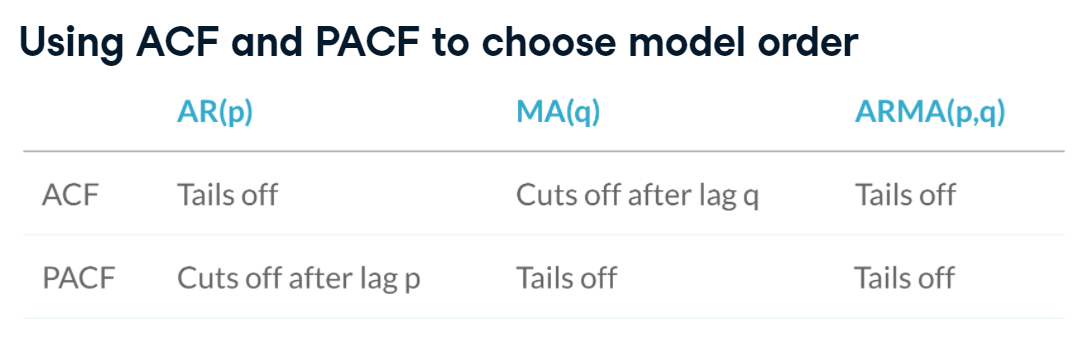

In [56]:
display(Image("./Image/ACF_PACF.png"))

In [62]:
google["High"]

2017-01-01    789.63
2017-01-02    791.34
2017-01-03    794.48
2017-01-04    807.90
2017-01-05    809.97
2017-01-06    809.13
2017-01-07    808.15
2017-01-08    807.39
2017-01-09    811.22
2017-01-10    807.14
2017-01-11    806.21
2017-01-12    809.48
2017-01-13    806.91
2017-01-14    820.87
2017-01-15    825.90
2017-01-16    835.77
2017-01-17    838.00
2017-01-18    841.95
2017-01-19    815.84
2017-01-20    801.25
Freq: D, Name: High, dtype: float64

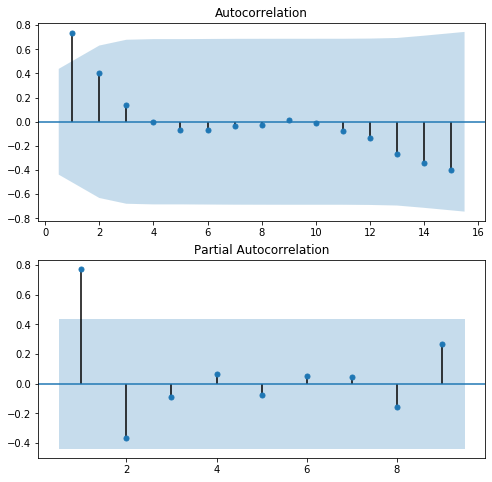

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,8))

plot_acf(google["High"], lags = 15, zero = False, ax = ax1)
plot_pacf(google["High"], lags = 9, zero = False, ax = ax2)

plt.show()